In [8]:
import numpy as np
import pandas as pd

In [9]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

data_path = 'report_data'

# 00. Evaluation

## Classification

### Confusion Matrix ([wiki](https://en.wikipedia.org/wiki/Confusion_matrix))

- True Positive: You predicted positive and it’s true.
- True Negative: You predicted negative and it’s true.
- False Positive: You predicted positive and it’s false.
- False Negative: You predicted negative and it’s false.

## Regression

## Data Sampling

# 01. Naive Bayes

## Basic

$$ P(C | w) = \frac {P(w | C) \cdot P(C)} {P(w)} $$

## Prepare Data

In [3]:

# shell scripts for downloading the data and placing it in a corresponding directory
!mkdir report_data & mkdir report_data/newsgroups
!curl -o report_data/newsgroups/news.tar.gz "http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz" -C -
# extract the files
!gzip -d < report_data/newsgroups/news.tar.gz | tar xf - --directory report_data/newsgroups
# !ls ./newsgroups/*

mkdir: mkdir: report_data: File exists
report_data/newsgroups: File exists
** Resuming transfer from byte position 14464277
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   389    0   389    0     0   1182      0 --:--:-- --:--:-- --:--:--  1178


In [4]:
import os

# Reference the paths to our dataset
base_path_newsgroups = "report_data/newsgroups/"
path_newsgroups_train = os.path.join(base_path_newsgroups, "20news-bydate-train")
path_newsgroups_test = os.path.join(base_path_newsgroups, "20news-bydate-test")

In [5]:
from mll2021ss.helpers.file import read_file, read_files
from mll2021ss.helpers.vectorizer import vectorize_by_grouping, vectorize_texts, vectorize_text_by_vocabulary, vectorize_texts_by_vocabulary
from mll2021ss.helpers.text import tokenize
from mll2021ss.helpers.features import extract_raw_features_and_targets

In [6]:
data_train = read_files(path_newsgroups_train)
data_test = read_files(path_newsgroups_test)

raw_features, raw_targets = extract_raw_features_and_targets(data_train)
raw_features_test, raw_targets_test = extract_raw_features_and_targets(data_test)

In [7]:
X1, vocabulary = vectorize_texts(raw_features)
Y1, classes_map = vectorize_by_grouping(np.array(raw_targets).reshape((-1, 1)))

X1_test = vectorize_texts_by_vocabulary(raw_features_test, vocabulary)
Y1_test, _ = vectorize_by_grouping(np.array(raw_targets_test).reshape((-1, 1)))

## Eval Modal

In [8]:
from mll2021ss.learning_algorithms.naive_bayes import naive_bayes_train, naive_bayes_predict
from mll2021ss.measurement.classification import accuracy

In [9]:
classes, prior_probability, likelihood = naive_bayes_train(X1, Y1)
Y1_hat_test, index = naive_bayes_predict(X1_test, classes, prior_probability, likelihood)

In [10]:
accuracy(Y1_test, Y1_hat_test)

array([0.72198619])

# 02. Linear Regression

## Basic

### normal equation

$$Xw = y$$
$$X^T X w = X^T Y$$
$$ w = (X.T @ X)^-1 @ X.T @ Y $$


### optimization target

$$J(\theta) = \frac 1 {2m} ((w^Tx + b) - y)^2$$
$$\frac {\partial J(\theta)} {w} = \frac 1 m ((w^Tx + b) - y) \cdot x, \textrm{    }\frac {\partial J(\theta)} {b} = \frac 1 m ((w^Tx + b) - y) $$

## Prepare Data

In [11]:
import pandas as pd
data = pd.read_csv("report_data/mllab-03-auto-mpg.csv")
X2 = data[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']].values
Y2 = data[['mpg']].values

## Eval model

In [12]:
from mll2021ss.learning_algorithms.normal_equation import normal_equation_train
from mll2021ss.learning_algorithms.linear_regression import linear_regression_cost, \
                                                            linear_regression_train, linear_regression_predict

from mll2021ss.measurement.regression import r2_score

In [13]:
w21 = normal_equation_train(np.insert(X2, 0, 1, axis=1), Y2)
Y2_hat = linear_regression_predict(np.insert(X2, 0, 1, axis=1), w21)

r2_score(Y2, Y2_hat)

0.8092552890383932

In [14]:
from mll2021ss.helpers.features import mean_normalizer, z_score_normalizer

normalize = z_score_normalizer(X2)
X2_normalized = normalize(X2)

In [15]:
w22 = linear_regression_train(np.insert(X2_normalized, 0, 1, axis=1), Y2)
Y2_hat2 = linear_regression_predict(np.insert(X2_normalized, 0, 1, axis=1), w22)

r2_score(Y2, Y2_hat2)

0.8092526651235419

In [16]:
w23 = linear_regression_train(np.insert(X2_normalized, 0, 1, axis=1), Y2, learning_rate=0.03, iteration_count=3000, batch_size=30)

Y2_hat3 = linear_regression_predict(np.insert(X2_normalized, 0, 1, axis=1), w23)
r2_score(Y2, Y2_hat3)

0.8089968722606913

# 03. Logistic Regression

## Basic

assumes the logarithm of the odds to be a linear combination of the inputs.
$$ log( \frac {p} {1-p} ) = \mathbf w^T \mathbf x  $$

we can get our Hypothesis Representation (as $p$ - the probability  that our output is 1)
$$ h_\theta(\mathbf x) = \frac 1 {1+ e^{-\mathbf w^T \mathbf x}} $$


### optimization target

$$ Loss(\hat y, y) = -y \cdot \log(\hat y) - (1-y) \cdot \log(1-\hat y) $$

## Prepare Data

In [2]:
import numpy as np

n_samples = 200

# generate class p
mean_p = [5, 9]
cov_p = [[2.5, 0.8], [0.8, 0.5]]
X_p = np.random.multivariate_normal(mean_p, cov_p, n_samples)

# generate class n
mean_n1, mean_n2 = [11, 3], [5, 2]
cov_n = [[3, -1.3], [-1.3, 1.2]]
X_n = np.vstack([
    np.random.multivariate_normal(mean_n1, cov_n, int(n_samples/2)),
    np.random.multivariate_normal(mean_n2, cov_n, int(n_samples/2))])

# combine targets
data_XY = np.vstack([
    np.hstack([X_p, np.ones((X_p.shape[0], 1))]),
    np.hstack([X_n, np.zeros((X_n.shape[0], 1))])
])
np.random.shuffle(data_XY)

data_test, data_train = data_XY[:80], data_XY[80:]

X3_train, Y3_train = data_train[:,:-1], data_train[:,-1:]
X3_test, Y3_test = data_test[:,:-1], data_test[:,-1:]

(-4.0, 15.0)

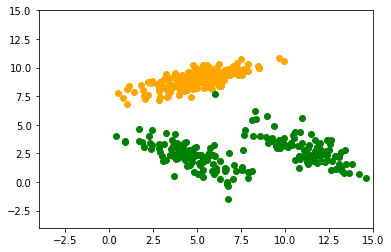

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X_p.T[0], X_p.T[1], color="orange")
ax.scatter(X_n.T[0], X_n.T[1], color="green")
ax.set_ylim(-4, 15)
ax.set_xlim(-4, 15)

In [56]:
import numpy as np

from interfaces.base_model import BaseModel

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def softmax(z):
    exps = np.exp(z)
    # print(exps.shape, np.sum(exps, axis=1, keepdims=True).shape)
    return exps / np.sum(exps, axis=1, keepdims=True)

def logistic_regression_eval(X, w):
    return softmax(X@w)


def logistic_regression_loss(y, y_hat):
    m = y.shape[0]
#     loss = np.sum(-y*np.log(y_hat), axis=1) 
#     return 1.0/m * np.sum(loss, axis=0)
    loss = np.sum(-y*np.log(y_hat), axis=1)
    return 1./m * np.sum(loss)


def logistic_regression_train(X, Y, learning_rate=0.1, iteration_count=1000, batch_size=None):
    m, n = X.shape
    _, c = Y.shape
    w = np.zeros((n, c))

    for i in range(iteration_count):

        X_chosen, Y_chosen = X, Y
        if batch_size != None:
            choices = np.random.choice(m, size=batch_size, replace=False)
            X_chosen, Y_chosen = X[choices, :], Y[choices, :]

        Y_hat = logistic_regression_eval(X_chosen, w)
        # print(Y_hat.shape, Y_chosen.shape, w.shape)
        gradient = X_chosen.T @ (Y_hat - Y_chosen)
        w -= 1.0/(batch_size or m) * learning_rate * gradient
        print(logistic_regression_loss(Y_chosen, Y_hat))
    return w


def logistic_regression_predict(X, w):
    Y_raw = logistic_regression_eval(X, w)
    Y_label = np.argmax(Y_raw, axis=1)
    Y_hat = (np.arange(Y_raw.shape[1]).reshape(1, -1) == Y_label.reshape(-1, 1)) * 1
    return Y_hat


class LogisticRegression (BaseModel):

    def learn(self, X, Y, learning_rate=0.1, iteration_count=1000, batch_size=None):
        self.w = logistic_regression_train(X, Y, learning_rate=learning_rate, iteration_count=iteration_count, batch_size=batch_size)

    def infer(self, X):
        return logistic_regression_predict(X, self.w)


In [57]:
Y3_train.shape

(320, 1)

### Eval Model

In [58]:
# from mll2021ss.learning_algorithms.logistic_regression import \
#     logistic_regression_loss, logistic_regression_train, logistic_regression_eval, logistic_regression_predict
from mll2021ss.measurement.classification import accuracy 

In [59]:
Y3_train2d = np.hstack([Y3_train, 1-Y3_train])

In [60]:
w3 = logistic_regression_train(np.insert(X3_train, 0, 1, axis=1), Y3_train2d)
Y3_train_hat = logistic_regression_eval(np.insert(X3_train, 0, 1, axis=1), w3)
logistic_regression_loss(Y3_train, Y3_train_hat)

0.6931471805599454
0.36107157953574387
0.3206382338067695
0.297834841180395
0.1923082549973157
0.17493602653422155
0.16516807693980054
0.15926411581475003
0.15440231203228116
0.1502589435240018
0.14667089732070446
0.14352459886080357
0.1407365452742978
0.13824372126270598
0.13599756137652683
0.1339599521975564
0.13210050839774298
0.13039466911121741
0.12882233778772276
0.1273668911733401
0.1260144445729919
0.12475329857033629
0.12357351650703706
0.12246659769617894
0.12142522174324642
0.12044304638073121
0.11951454606219845
0.11863488194574293
0.11779979629784972
0.1170055260753621
0.11624873170051049
0.11552643797000264
0.11483598472861896
0.11417498545619742
0.11354129231039559
0.1129329664689146
0.1123482528474618
0.11178555845067246
0.1112434337550003
0.11072055663445696
0.11021571842891897
0.10972781182570164
0.10925582028214215
0.1087988087630325
0.10835591560418618
0.10792634534399453
0.10750936238990416
0.10710428540741086
0.10671048233626473
0.10632736595279331
0.1059543899091

0.06541579744705743
0.06535386735674979
0.06529204533616055
0.06523033111873913
0.06516872443930953
0.06510722503405396
0.06504583264049692
0.06498454699748964
0.06492336784519451
0.06486229492506995
0.06480132797985548
0.06474046675355695
0.06467971099143204
0.0646190604399761
0.06455851484690804
0.06449807396115648
0.06443773753284629
0.06437750531328493
0.06431737705494961
0.06425735251147405
0.06419743143763577
0.0641376135893436
0.06407789872362517
0.06401828659861479
0.0639587769735414
0.06389936960871678
0.06384006426552391
0.06378086070640546
0.06372175869485251
0.06366275799539349
0.06360385837358322
0.06354505959599206
0.0634863614301953
0.06342776364476287
0.06336926600924873
0.06331086829418109
0.06325257027105212
0.06319437171230828
0.06313627239134059
0.063078272082475
0.06302037056096314
0.06296256760297296
0.06290486298557962
0.06284725648675647
0.06278974788536627
0.06273233696115245
0.06267502349473043
0.06261780726757932
0.06256068806203337
0.06250366566127397
0.0624

0.041984529100761864
0.041959167130304356
0.04193383939314165
0.04190854582772776


2.2498873675846087

In [21]:
Y3_test_hat = logistic_regression_predict(np.insert(X3_test, 0, 1, axis=1), w3)
accuracy(Y3_test, Y3_test_hat)

array([0.9875])

# 04. k-means

## Prepare Data

In [22]:
n_pre_cluster = 100
cluster = [
    ([5, 9], [[2.5, 0.8], [0.8, 0.5]]),
    ([11, 3], [[3, -1.3], [-1.3, 1.2]]),
    ([5, 2], [[3, -1.3], [-1.3, 1.2]])
]
X4 = np.vstack([np.random.multivariate_normal(mean, cov, n_pre_cluster) for mean, cov in cluster])

## Eval Model

In [23]:
from mll2021ss.learning_algorithms.k_means import k_means_loss, k_means_train, k_means_predict

In [24]:
# X_train from 03
centroids = k_means_train(X4, 3, iteration_count=1000)
Y4_hat = k_means_predict(X4, centroids)
k_means_loss(X4, Y4_hat), centroids

(75.06338500391695,
 array([[ 5.19970415,  9.0303833 ],
        [ 4.85111969,  2.12311575],
        [11.07092901,  2.9777813 ]]))

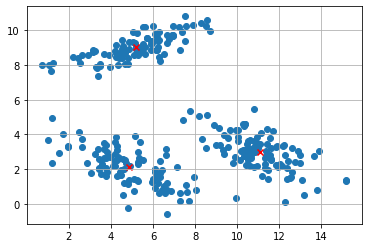

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X4[:, 0], X4[:, 1], marker='o')
plt.grid()
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color="red")

In [26]:
## TODO k means performance

# 05. Decision Trees

## Prepare Data

In [27]:
#shell scripts for downloading the data and placing it in a corresponding directory
!mkdir report_data/CAR 
!curl -o report_data/CAR/data "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
!curl -o report_data/CAR/description "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names"
#download the description and display it here.
# !cat CAR/description

mkdir: report_data/CAR: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51867  100 51867    0     0  76954      0 --:--:-- --:--:-- --:--:-- 76840
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3097  100  3097    0     0   9272      0 --:--:-- --:--:-- --:--:--  9272


In [28]:
# csv-file has no header, so we define it manually
col_names = ['price_buy', 'price_main', 'n_doors', 'n_persons', 'lug_boot', 'safety', 'recommendation']
df = pd.read_csv("report_data/CAR/data", header=None, names=col_names)
X5, Y5 = df.values[:, :6], df.values[:, 6]
df.head()

,price_buy,price_main,n_doors,n_persons,lug_boot,safety,recommendation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Eval Model

In [29]:
from mll2021ss.learning_algorithms.decision_tree import ID3_train, ID3_predict, gini
from mll2021ss.measurement.data_sampling import get_k_folds
from mll2021ss.measurement.classification import accuracy

np.random.seed(0)
k = 10
folds = get_k_folds(X5.shape[0], k)
accs = []
for train_indices, test_indices in folds:
    X_train, Y_train = X5[train_indices], Y5[train_indices]
    X_test, Y_test = X5[test_indices], Y5[test_indices]
    
    t = ID3_train(X_train, Y_train, impurity_function=gini)
    Y_test_hat = ID3_predict(X_test, t)
    
    accs.append(accuracy(Y_test, Y_test_hat))
    
np.sum(accs) / len(accs)

0.9348837209302326

# 06. Neural Network

## Basic of Neural Network

### Forward Propagation

$$ Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$ A^{[1]} = g (Z^{[1]})$$

$$ Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
$$ A^{[l]} = g (Z^{[l]})$$

### Backward Propagation


$$ \partial \frac {J(\theta)} {\partial \mathbf A^{[L]}} = 
- \frac {Y} {A^{[L]}}  + \frac {1 - Y} {1 - A^{[L]}} $$

$$\vdots $$

---

$$ \partial \frac {J(\theta)} {\partial \mathbf A^{[l]}} = 
 \mathbf W^{[l]}(\partial \frac {J(\theta)} {\partial \mathbf Z^{[l+1]}}) $$

$$ \partial \frac {J(\theta)} {\partial \mathbf Z^{[l]}} = \partial \frac {J(\theta)} {\partial \mathbf A^{[l]} } \ast g'^{[l]}(\mathbf Z^{[l]}) $$

$$ \partial \frac {J(\theta)} {\partial \mathbf W^{[l]}} = \frac 1 m \mathbf A^{[l-1]}(\partial \frac {J(\theta)} {\partial \mathbf Z^{[l]}})^T $$

---

$$\vdots $$

$$ \partial \frac {J(\theta)} {\partial \mathbf W^{[1]}} = \frac 1 m \mathbf X (\partial \frac {J(\theta)} {\partial \mathbf Z^{[1]}})^T $$



## Prepare Data

In [30]:
import sklearn.datasets

np.random.seed(0)
X6, Y6 = sklearn.datasets.make_moons(200, noise=0.20)
classes6 = np.unique(Y6).reshape(1, -1)
Y6 = (classes6 == Y6.reshape(-1, 1)) * 1
X6_train, Y6_train = X6[:180], Y6[:180]
X6_test, Y6_test = X6[180:], Y6[180:]

## Eval Model

In [31]:
from mll2021ss.learning_algorithms.neural_network import neural_network_train, neural_network_predict, \
    tanh_gradient, softmax, softmax_gradient
from mll2021ss.measurement.classification import accuracy

In [32]:
layers = [(4, np.tanh, tanh_gradient), (2, softmax, softmax_gradient)]
np.random.seed(0)

Ws6, bs6 = neural_network_train(X6_train, Y6_train, layers, learning_rate=0.01, iteration_count=3000)
Y6_hat = neural_network_predict(X6_test, Ws6, bs6, layers)
accuracy(Y6_test, Y6_hat)

array([1., 1.])

# 07. SVM

In [33]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt" 
data = pd.read_csv(url, header = None, sep='\t').to_numpy()

np.random.seed(1)

msk = np.random.rand(len(data)) < 0.8
X7 = np.insert(data[:, :3], 0, 1, axis=1)
Y7 = np.unique(data[:, -1:], return_inverse=True)[1].reshape(-1, 1) # transfer y to 0, 1

X7_train, Y7_train = X7[msk], Y7[msk]
X7_test, Y7_test = X7[~msk], Y7[~msk]

In [34]:
# m = 100000 # 245057
from mll2021ss.learning_algorithms.support_vector_machine import \
    support_vector_machine_train, support_vector_machine_predict
from mll2021ss.measurement.classification import accuracy

w7 = support_vector_machine_train(X7_train, Y7_train, big_c=1, learning_rate=0.01, iteration_count=100, batch_size=200)
Y7_test_hat = support_vector_machine_predict(X7_test, w7)
accuracy(Y7_test_hat, Y7_test)

array([0.93418901])

In [35]:
## TODO learning rate decay